In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)


In [ ]:
fato_custos = pd.read_csv("/home/rodrigo/controladoria-industrial/data/processed/fato_custos_tratado.csv")
df_producao = pd.read_csv("/home/rodrigo/controladoria-industrial/data/processed/producao_tratada.csv")
df_produtos = pd.read_csv("/home/rodrigo/controladoria-industrial/data/raw/produtos_raw.csv")


In [5]:
custos_produtivos = fato_custos[
    fato_custos["tipo"] == "Produtivo"
]


In [6]:
custos_agregados = (
    custos_produtivos
    .groupby(["ano_mes", "centro_custo"])["valor"]
    .sum()
    .reset_index()
)


In [7]:
df_producao["ano_mes"] = pd.to_datetime(df_producao["data"]).dt.to_period("M").astype(str)

producao_agregada = (
    df_producao
    .groupby(["ano_mes", "produto", "centro_custo"])
    .agg({
        "quantidade_produzida": "sum",
        "horas_maquina": "sum"
    })
    .reset_index()
)


In [8]:
base_custo_real = producao_agregada.merge(
    custos_agregados,
    on=["ano_mes", "centro_custo"],
    how="left"
)


In [9]:
base_custo_real["custo_unitario_real"] = (
    base_custo_real["valor"] /
    base_custo_real["quantidade_produzida"]
)


In [10]:
base_custo_real = base_custo_real.merge(
    df_produtos[["produto", "custo_padrao_unitario"]],
    on="produto",
    how="left"
)


In [11]:
base_custo_real["desvio_unitario"] = (
    base_custo_real["custo_unitario_real"] -
    base_custo_real["custo_padrao_unitario"]
)

base_custo_real["percentual_desvio"] = (
    base_custo_real["desvio_unitario"] /
    base_custo_real["custo_padrao_unitario"]
) * 100


In [12]:
base_custo_real.sort_values(
    "percentual_desvio",
    ascending=False
).head(10)


,ano_mes,produto,centro_custo,quantidade_produzida,horas_maquina,valor,custo_unitario_real,custo_padrao_unitario,desvio_unitario,percentual_desvio
99,2024-02,PROD_E,CC100,72,27.25,"97,097.59","1,348.58",9.80,"1,338.78","13,661.00"
53,2023-08,PROD_D,CC200,100,39.33,"113,312.02","1,133.12",12.30,"1,120.82","9,112.36"
68,2023-10,PROD_D,CC100,72,32.69,"75,025.59","1,042.02",12.30,"1,029.72","8,371.72"
133,2024-08,PROD_A,CC100,66,6.04,"118,446.27","1,794.64",25.00,"1,769.64","7,078.56"
131,2024-07,PROD_E,CC100,97,12.86,"58,141.02",599.39,9.80,589.59,"6,016.24"
27,2023-04,PROD_E,CC100,135,19.22,"73,812.33",546.76,9.80,536.96,"5,479.16"
31,2023-05,PROD_B,CC200,80,10.81,"112,500.48","1,406.26",32.50,"1,373.76","4,226.94"
67,2023-10,PROD_C,CC200,88,28.49,"66,217.16",752.47,18.70,733.77,"3,923.89"
25,2023-04,PROD_C,CC100,100,31.61,"73,812.33",738.12,18.70,719.42,"3,847.18"
32,2023-05,PROD_C,CC100,109,36.14,"76,205.08",699.13,18.70,680.43,"3,638.66"


In [13]:
base_custo_real.sort_values(
    "percentual_desvio"
).head(10)


,ano_mes,produto,centro_custo,quantidade_produzida,horas_maquina,valor,custo_unitario_real,custo_padrao_unitario,desvio_unitario,percentual_desvio
45,2023-07,PROD_C,CC100,390,37.91,"2,870.78",7.36,18.70,-11.34,-60.64
119,2024-06,PROD_B,CC100,517,81.78,"11,241.48",21.74,32.50,-10.76,-33.10
47,2023-07,PROD_D,CC100,249,36.67,"2,870.78",11.53,12.30,-0.77,-6.27
0,2023-01,PROD_A,CC100,454,32.60,"10,780.18",23.74,25.00,-1.26,-5.02
94,2024-02,PROD_B,CC200,980,57.38,"36,760.46",37.51,32.50,5.01,15.42
118,2024-06,PROD_A,CC100,375,40.87,"11,241.48",29.98,25.00,4.98,19.91
125,2024-07,PROD_A,CC200,1103,109.67,"33,699.88",30.55,25.00,5.55,22.21
55,2023-09,PROD_A,CC100,956,15.94,"31,310.67",32.75,25.00,7.75,31.01
43,2023-07,PROD_B,CC100,62,11.28,"2,870.78",46.30,32.50,13.80,42.47
126,2024-07,PROD_B,CC100,1129,46.23,"58,141.02",51.50,32.50,19.00,58.45


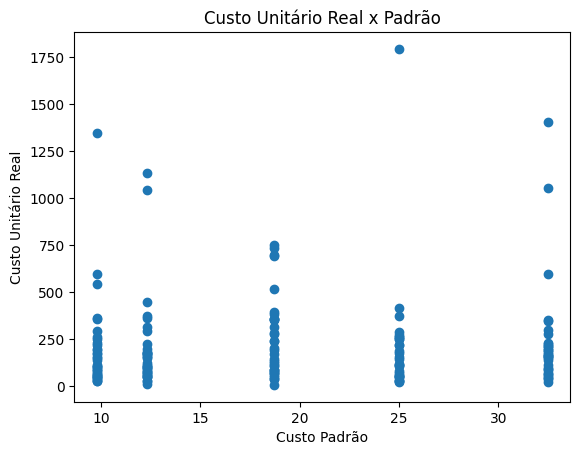

In [14]:
plt.figure()
plt.scatter(
    base_custo_real["custo_padrao_unitario"],
    base_custo_real["custo_unitario_real"]
)
plt.xlabel("Custo Padrão")
plt.ylabel("Custo Unitário Real")
plt.title("Custo Unitário Real x Padrão")
plt.show()
